# Word Embeddings (word2vec)
Leah Hogenmiller (lmh2ur)

## Set Up

In [72]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [73]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

In [74]:
BAG = CHAPS

## Importing Tables

In [75]:
CORPUS = pd.read_csv('CORPUS.csv').set_index(OHCO)
VOCAB = pd.read_csv('VOCAB.csv')
LIB = pd.read_csv('LIB.csv')

In [76]:
LIB

,book_id,title,author,date,source_file_path
0,863,The Mysterious Affair at Styles,Agatha Christie,1920,pg863.txt
1,1155,The Secret Adversary,Agatha Christie,1922,pg1155.txt
2,58866,The Murder on the Links,Agatha Christie,1923,pg58866.txt
3,61168,The Man in the Brown Suit,Agatha Christie,1924,pg61168.txt
4,65238,The Secret of Chimneys,Agatha Christie,1925,pg65238.txt
5,69087,The Murder of Roger Ackroyd,Agatha Christie,1926,pg69087.txt
6,70114,The Big Four,Agatha Christie,1927,pg70114.txt
7,244,A Study in Scarlet,Arthur Conan Doyle,1887,pg244.txt
8,834,The Memoirs of Sherlock Holmes,Arthur Conan Doyle,1893,pg834.txt
9,1661,The Adventures of Sherlock Holmes,Arthur Conan Doyle,1892,pg1661.txt


In [77]:
POS = ['NN','VB']

## Christie

In [78]:
CHRISTIE = CORPUS.loc[[863, 1155, 58866, 61168, 65238, 69087, 70114]]
CHRISTIE = CHRISTIE[CHRISTIE.pos.isin(POS)]

In [79]:
CHRISTIE_DOCS = CHRISTIE\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
CHRISTIE_DOCS = [doc for doc in CHRISTIE_DOCS if len(doc) > 1] # Lose single word docs

In [80]:
CHRISTIE_VOCAB = CHRISTIE.term_str.value_counts().to_frame('n').sort_index()
CHRISTIE_VOCAB.index.name = 'term_str'
CHRISTIE_VOCAB['max_pos'] = CHRISTIE[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1).str[:2]

In [81]:
CHRISTIE_VOCAB.head()

,n,max_pos
term_str,,
1,3,NN
100,1,VB
100000,1,NN
17th,1,NN
2,2,NN


In [82]:
pd.Series(CHRISTIE_DOCS).to_csv('CHRISTIE_DOCS.csv', index=False, header=False)
CHRISTIE_VOCAB.to_csv('CHRISITE_VOCAB.csv')

### Word Embedding

In [83]:
# word2vec parameters
w2v_params = dict(
    window = 2,
    size = 246,
    min_count = 50,
    workers = 4
)

In [84]:
christie_model = word2vec.Word2Vec(CHRISTIE_DOCS, **w2v_params)

In [85]:
CHRISTIE_W2V = pd.DataFrame(christie_model.wv.vectors_norm, index=christie_model.wv.vocab.keys())
CHRISTIE_W2V.to_csv('CHRISTIE_W2V.csv')

In [86]:
christie_coords = pd.DataFrame(
    dict(
        vector = [christie_model.wv.get_vector(w) for w in christie_model.wv.vocab], 
        term_str = christie_model.wv.vocab.keys()
    )).set_index('term_str')

### TSNE

In [87]:
tsne_engine = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
christie_tsne = tsne_engine.fit_transform(christie_coords.vector.to_list())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [88]:
christie_coords['x'] = christie_tsne[:,0]
christie_coords['y'] = christie_tsne[:,1]

### Add Vocab Features

In [89]:
if christie_coords.shape[1] == 3:
    christie_coords = christie_coords.merge(CHRISTIE_VOCAB.reset_index(), on='term_str')
    christie_coords = christie_coords.set_index('term_str')

In [90]:
christie_coords.head()

,vector,x,y,n,max_pos
term_str,,,,,
interest,"[0.15294643, -0.0151961, 0.03958985, -0.055319...",-5.574168,0.200825,110,NN
time,"[0.14850906, -0.013717292, 0.03844658, -0.0565...",-4.156497,-2.148122,847,NN
view,"[0.1477148, -0.010821302, 0.035680607, -0.0559...",-11.506228,-2.280139,66,NN
world,"[0.15326971, -0.012639951, 0.039553225, -0.057...",-1.303779,2.655815,134,NN
it,"[0.14566225, -0.01280718, 0.03608672, -0.05532...",6.703272,10.660799,1577,NN


In [91]:
christie_coords.to_csv('christie_coords.csv')

### Plot 

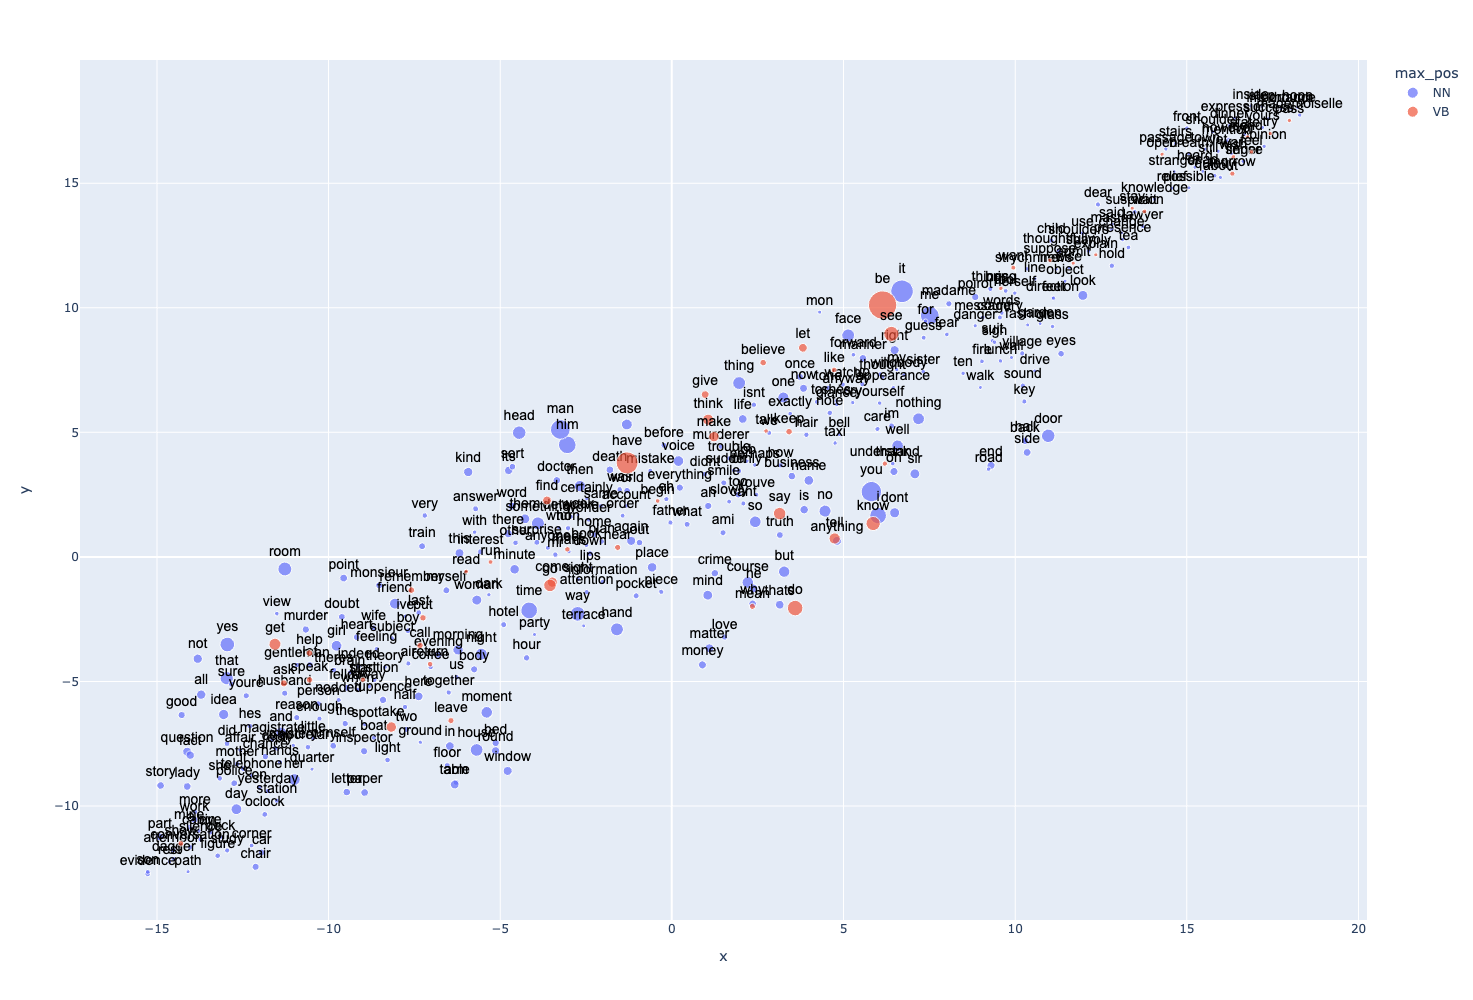

In [92]:
px.scatter(christie_coords.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='n',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

## Conan Doyle

In [93]:
CONAN = CORPUS.loc[[244, 834, 1661, 2097, 3070, 3289]]
CONAN = CONAN[CONAN.pos.isin(POS)]

In [94]:
CONAN_DOCS = CONAN\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
CONAN_DOCS = [doc for doc in CONAN_DOCS if len(doc) > 1] # Lose single word docs

In [95]:
CONAN_VOCAB = CONAN.term_str.value_counts().to_frame('n').sort_index()
CONAN_VOCAB.index.name = 'term_str'
CONAN_VOCAB['max_pos'] = CONAN[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1).str[:2]

In [96]:
CONAN_VOCAB.head()

,n,max_pos
term_str,,
10,1,VB
10th,1,NN
12th,1,NN
16,1,NN
1742,1,NN


In [97]:
pd.Series(CONAN_DOCS).to_csv('CONAN_DOCS.csv', index=False, header=False)
CONAN_VOCAB.to_csv('CONAN_VOCAB.csv')

### Word Embedding

In [98]:
conan_model = word2vec.Word2Vec(CONAN_DOCS, **w2v_params)

In [99]:
CONAN_W2V = pd.DataFrame(conan_model.wv.vectors_norm, index=conan_model.wv.vocab.keys())
CONAN_W2V.to_csv('CONAN_W2V.csv')

In [100]:
conan_coords = pd.DataFrame(
    dict(
        vector = [conan_model.wv.get_vector(w) for w in conan_model.wv.vocab], 
        term_str = conan_model.wv.vocab.keys()
    )).set_index('term_str')

### TSNE

In [101]:
conan_tsne = tsne_engine.fit_transform(conan_coords.vector.to_list())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [102]:
conan_coords['x'] = conan_tsne[:,0]
conan_coords['y'] = conan_tsne[:,1]

In [103]:
if conan_coords.shape[1] == 3:
    conan_coords = conan_coords.merge(CONAN_VOCAB.reset_index(), on='term_str')
    conan_coords = conan_coords.set_index('term_str')

In [104]:
conan_coords.head()

,vector,x,y,n,max_pos
term_str,,,,,
year,"[0.16502933, 0.005421871, 0.11243362, -0.05818...",-9.989048,0.168242,84,NN
go,"[0.15828261, 0.0063714953, 0.10994961, -0.0579...",1.445098,2.619682,288,VB
course,"[0.16404663, 0.0032303042, 0.11195534, -0.0586...",0.685414,2.640100,228,NN
time,"[0.15434135, 0.0035466277, 0.108833924, -0.057...",5.688365,-0.193830,620,NN
it,"[0.15474008, 0.0037339812, 0.1074243, -0.05714...",7.625571,4.368297,1467,NN


In [105]:
conan_coords.to_csv('conan_coords.csv')

### Plot

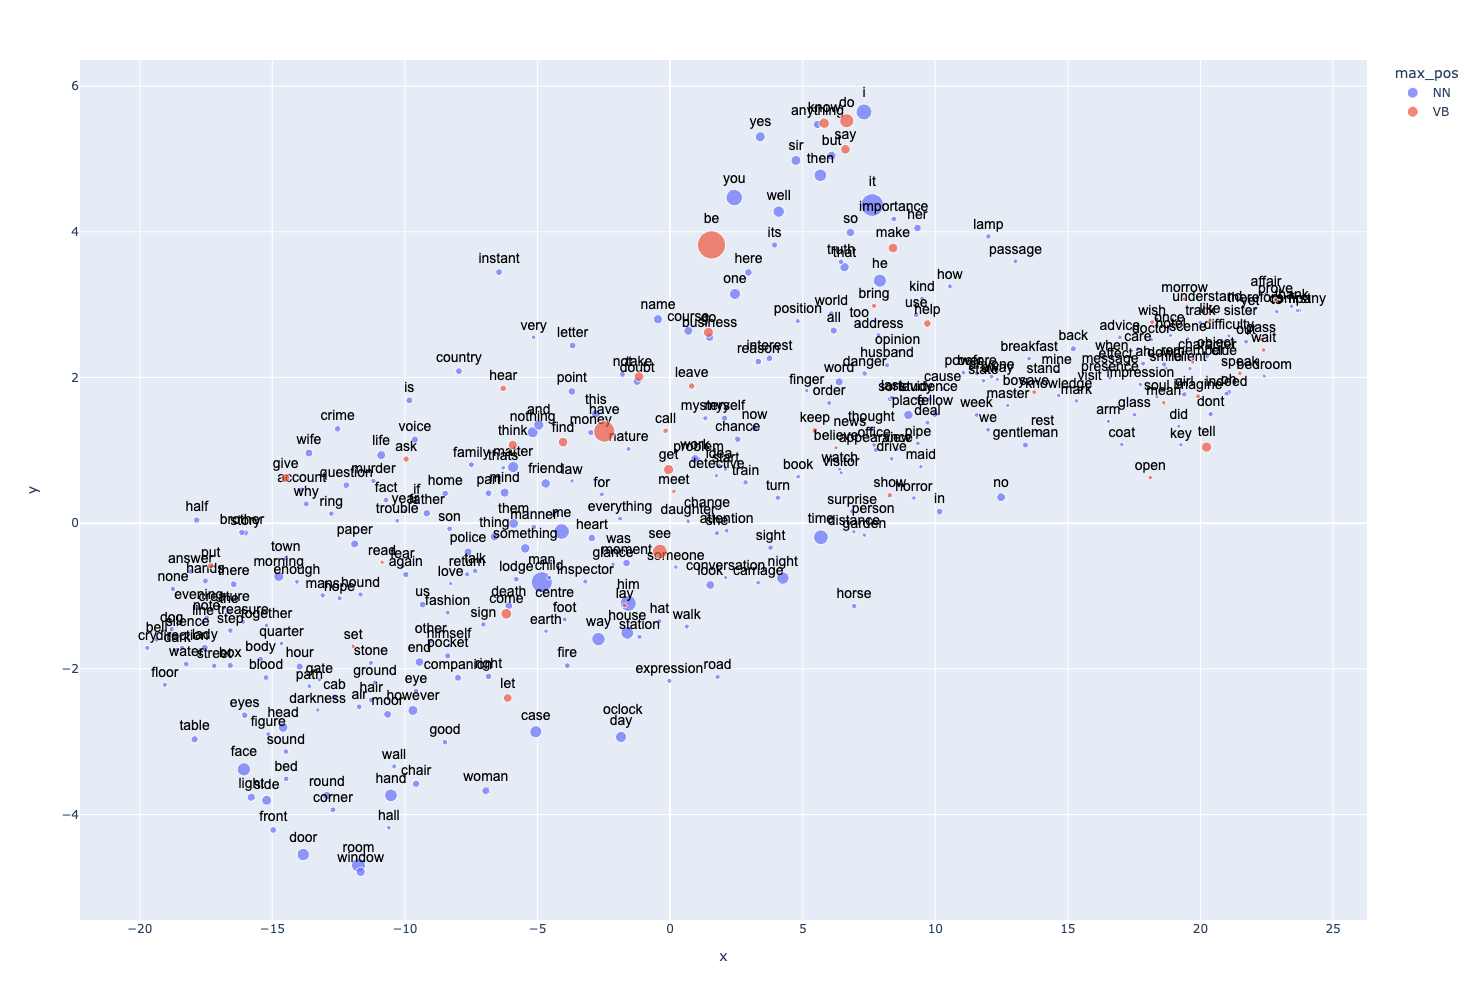

In [106]:
px.scatter(conan_coords.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='n',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

## Analogies

In [107]:
def get_most_similar_conan(positive, negative=None):
    return pd.DataFrame(conan_model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [108]:
def get_most_similar_christie(positive, negative=None):
    return pd.DataFrame(christie_model.wv.most_similar(positive, negative), columns=['term', 'sim'])

### Murder

In [109]:
get_most_similar_christie('murder')

,term,sim
0,husband,0.999811
1,mother,0.999809
2,theory,0.999808
3,before,0.999806
4,afternoon,0.999804
5,words,0.999804
6,a,0.999800
7,admit,0.999800
8,show,0.999798
9,reply,0.999797


In [110]:
get_most_similar_conan('murder')

,term,sim
0,manner,0.999853
1,kind,0.999851
2,nature,0.999849
3,thats,0.999847
4,cause,0.999847
5,fact,0.999846
6,enough,0.999846
7,attention,0.999846
8,if,0.999846
9,love,0.999845


### Crime

In [117]:
get_most_similar_christie('crime')

,term,sim
0,murder,0.999776
1,course,0.999775
2,mind,0.999770
3,what,0.999770
4,fact,0.999768
5,wife,0.999761
6,will,0.999761
7,death,0.999761
8,afternoon,0.999760
9,them,0.999759


In [118]:
get_most_similar_conan('crime')

,term,sim
0,them,0.999841
1,account,0.999833
2,murder,0.999832
3,if,0.999832
4,interest,0.999826
5,mind,0.999824
6,deal,0.999823
7,trouble,0.999823
8,change,0.999821
9,have,0.999820


### Detective

In [115]:
get_most_similar_christie('detective')

,term,sim
0,week,0.999875
1,rest,0.999862
2,a,0.999861
3,brain,0.999855
4,enough,0.999854
5,little,0.999853
6,anyone,0.999853
7,start,0.999852
8,indeed,0.999852
9,when,0.999851


In [116]:
get_most_similar_conan('detective')

,term,sim
0,story,0.999865
1,enough,0.999862
2,start,0.999862
3,week,0.999861
4,news,0.999860
5,anyone,0.999857
6,have,0.999856
7,watch,0.999856
8,trouble,0.999855
9,care,0.999854
